In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2025-08-13 12:18:14.256442: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 12:18:14.261467: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-13 12:18:14.303905: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-13 12:18:14.345032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755076694.382962   69010 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755076694.39

In [2]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [3]:
import tensorflow as tf
print("Devices:", tf.config.list_physical_devices())


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


W0000 00:00:1755076702.386801   69010 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
from sklearn.preprocessing import MinMaxScaler


my_file = "./pentilfuran.MDE"
df = pd.read_csv(
    my_file,
    sep=r"\s+",
    comment='#',
    names=["Step", "T", "E_KS", "E_tot", "Vol", "P"]
)

rows_per_group = 900

# Adaugă poziția în grup în df
df['pos_in_group'] = df.groupby('Step').cumcount()

# # Varianta 1: for + concat (comentată)
# start_for = time.time()
# df_data_for = pd.DataFrame()
# for i in df['Step'].unique():
#     df1 = df[df['Step'] == i].reset_index(drop=True)
#     df1['pos_in_group'] = df1.index
#     df_data_for = pd.concat([df_data_for, df1.iloc[1:rows_per_group+1]], ignore_index=True)
# time_for = time.time() - start_for

# Varianta 2: cumcount + mask
start_cumcount = time.time()
mask = df.groupby("Step").cumcount().between(1, rows_per_group)
df_data = df[mask].copy()
df_data['pos_in_group'] = df.loc[mask, 'pos_in_group']
time_cumcount = time.time() - start_cumcount

# Optional: sortare după Step și pos_in_group
df_data = df_data.sort_values(['Step', 'pos_in_group']).reset_index(drop=True)

print(f"Dimensiunea după filtrare: {len(df_data)} rânduri")
print(f" Range E_KS: [{df_data['E_KS'].min():.6f}, {df_data['E_KS'].max():.6f}] eV")

# Scalează energia (opțional)
scaler = MinMaxScaler()
df_data['Energy_scaled'] = scaler.fit_transform(df_data[['E_tot']])

# Dacă vrei să vezi și valorile originale alături, poți face așa:
print("\nPrimele 10 valori originale E_tot și scalate Energy_scaled:")
print(df_data[['E_tot', 'Energy_scaled']].head(10))


print(f"Timp varianta cumcount: {time_cumcount:.4f} secunde")


✅ Dimensiunea după filtrare: 90000 rânduri
🎯 Range E_KS: [-2131.365240, -2130.822140] eV

Primele 10 valori originale E_tot și scalate Energy_scaled:
        E_tot  Energy_scaled
0 -2131.04545       0.484600
1 -2131.06881       0.444427
2 -2131.09338       0.402174
3 -2131.11948       0.357289
4 -2131.14642       0.310960
5 -2131.17316       0.264974
6 -2131.19881       0.220864
7 -2131.22257       0.180003
8 -2131.24331       0.144336
9 -2131.26095       0.114000
Timp varianta cumcount: 0.0060 secunde


In [6]:
# ## 2. Preprocesare Simplificată

# %%
# Selectare doar coloanele necesare
features = ['T', 'E_tot', 'Vol', 'P']  # Features pentru predicție
target = 'E_KS'                        # Target

# Extrage datele
X_data = df_data[features].values
y_data = df_data[target].values

print(f"Shape features: {X_data.shape}")
print(f"Shape target: {y_data.shape}")

# Scalare
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_data)
y_scaled = scaler_y.fit_transform(y_data.reshape(-1, 1)).flatten()

print("Scalare completă")

Shape features: (90000, 4)
Shape target: (90000,)
Scalare completă


In [7]:
def create_sequences_multi_step(X, y, sequence_length, out_steps):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length - out_steps + 1):
        sequences_X.append(X[i:i + sequence_length])
        sequences_y.append(y[i + sequence_length:i + sequence_length + out_steps])
    return np.array(sequences_X), np.array(sequences_y)

# Parametri
SEQUENCE_LENGTH = 200
OUT_STEPS = 20

X_seq, y_seq = create_sequences_multi_step(X_scaled, y_scaled, SEQUENCE_LENGTH, OUT_STEPS)

print(f"X shape: {X_seq.shape}")  # (num_samples, 200, num_features)
print(f"y shape: {y_seq.shape}")  # (num_samples, 20)


X shape: (89781, 200, 4)
y shape: (89781, 20)


In [8]:
total_samples = len(X_seq)
train_size = int(total_samples * 0.7)   # 70% pentru antrenare
val_size = int(total_samples * 0.15)    # 15% pentru validare
test_size = total_samples - train_size - val_size  # restul pentru test

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print(f"Dimensiuni train: {X_train.shape}, {y_train.shape}")
print(f"Dimensiuni val: {X_val.shape}, {y_val.shape}")
print(f"Dimensiuni test: {X_test.shape}, {y_test.shape}")


Dimensiuni train: (62846, 200, 4), (62846, 20)
Dimensiuni val: (13467, 200, 4), (13467, 20)
Dimensiuni test: (13468, 200, 4), (13468, 20)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def build_optimized_lstm_model(input_shape, out_steps=20):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),
        LSTM(64, return_sequences=False, dropout=0.2),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dense(out_steps)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

# Construiește modelul
model = build_optimized_lstm_model(input_shape=(200, 4), out_steps=20)
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200, 128)       │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,732 (483.33 KB)

 Trainable params: 123,348 (481.83 KB)

 Non-trainable params: 384 (1.50 KB)

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


# Evaluare
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Epoch 1/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 101s 101ms/step - loss: 0.2497 - mae: 0.3354 - val_loss: 0.0477 - val_mae: 0.1281 - learning_rate: 0.0010
Epoch 2/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 99s 100ms/step - loss: 0.1112 - mae: 0.2119 - val_loss: 0.0415 - val_mae: 0.1205 - learning_rate: 0.0010
Epoch 3/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 99s 101ms/step - loss: 0.0932 - mae: 0.1910 - val_loss: 0.0493 - val_mae: 0.1222 - learning_rate: 0.0010
Epoch 4/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 100s 102ms/step - loss: 0.0780 - mae: 0.1685 - val_loss: 0.0320 - val_mae: 0.1190 - learning_rate: 0.0010
Epoch 5/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 101s 102ms/step - loss: 0.0762 - mae: 0.1651 - val_loss: 0.0196 - val_mae: 0.0966 - learning_rate: 0.0010
Epoch 6/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 100s 102ms/step - loss: 0.0665 - mae: 0.1508 - val_loss: 0.0181 - val_mae: 0.0931 - learning_rate: 0.0010
Epoch 7/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 100s 101ms/step - loss: 0.0631 - mae: 0.1423 - val_loss: 0.0144 - val_mae: 0.0871 - le

🏆 Performanța modelului:
   ├── MSE: 0.00021542 eV²
   ├── MAE: 0.01069000 eV
   ├── RMSE: 0.01467721 eV
   ├── MAPE: 0.00%
   └── R²: 0.990559 (99.06%)

📏 Context E_KS:
   ├── Range: [-2131.365240, -2130.822560] eV
   └── Amplitudine: 0.542680 eV


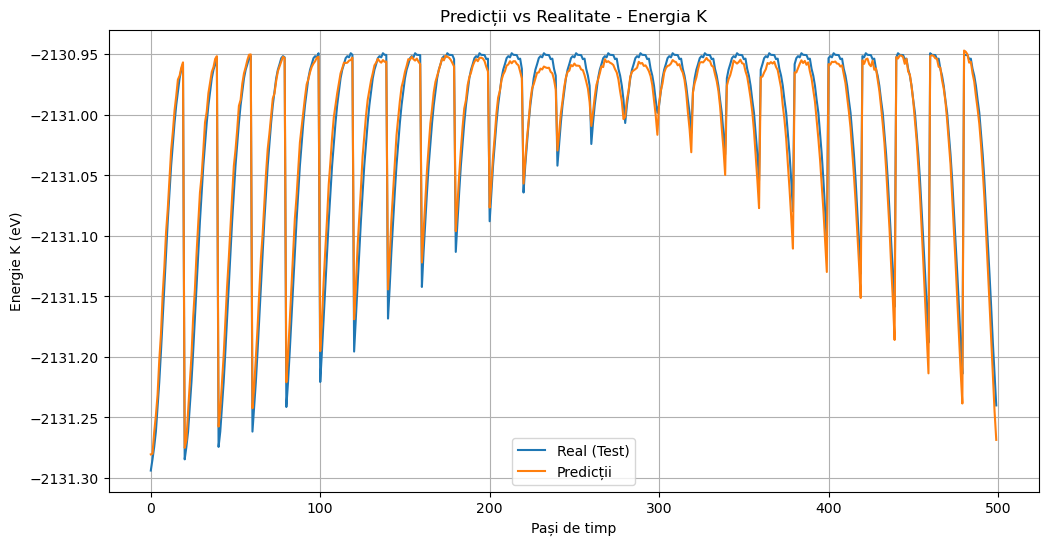

Modelul a fost salvat ca 'final_lstm_model.keras'


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictii pe setul de test
y_pred = model.predict(X_test, verbose=0)

# Inversare scalare pentru a reveni la valorile originale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calcul metrici
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# MAPE (doar dacă valorile reale nu includ zero)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"🏆 Performanța modelului:")
print(f"   ├── MSE: {mse:.8f} eV²")
print(f"   ├── MAE: {mae:.8f} eV")
print(f"   ├── RMSE: {rmse:.8f} eV")
print(f"   ├── MAPE: {mape:.2f}%")
print(f"   └── R²: {r2:.6f} ({r2*100:.2f}%)")

print(f"\n📏 Context E_KS:")
print(f"   ├── Range: [{y_test_original.min():.6f}, {y_test_original.max():.6f}] eV")
print(f"   └── Amplitudine: {y_test_original.max() - y_test_original.min():.6f} eV")

# Plot comparativ predicții vs realitate
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:500], label='Real (Test)')
plt.plot(y_pred_original[:500], label='Predicții')
plt.title('Predicții vs Realitate - Energia K')
plt.xlabel('Pași de timp')
plt.ylabel('Energie K (eV)')
plt.legend()
plt.grid(True)
plt.show()

# Salvare model final
model.save('final_lstm_model.keras')
print("Modelul a fost salvat ca 'final_lstm_model.keras'")


421/421 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step
(13468, 20) (13468, 200, 4) (13468, 20)
(269360, 1) (269360, 1)


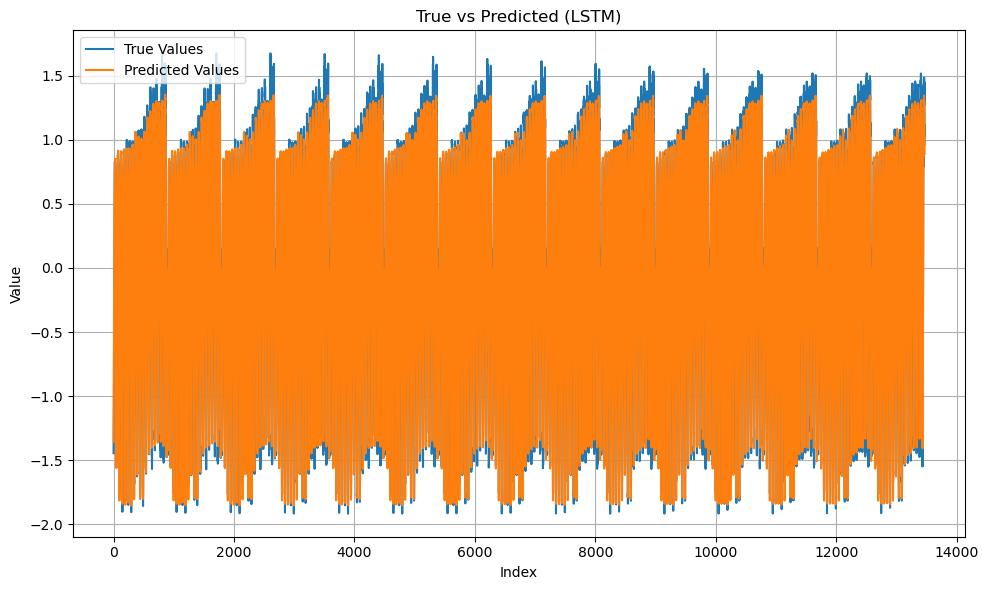

In [13]:
import matplotlib.pyplot as plt

# Predicții
predictions = model.predict(X_test)
print(predictions.shape, X_test.shape, y_test.shape)

# Inversare scaling (dacă folosești scaler pe ieșire)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
print(predictions_inverted.shape, y_test_inverted.shape)

# Grafic True vs Predicted pentru prima valoare din fiecare fereastră
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values')
plt.plot(predictions[:, 0], label='Predicted Values')
plt.title('True vs Predicted (LSTM)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🏆 Performanța modelului (date normalizate):
   ├── MSE: 0.00942866
   ├── MAE: 0.07072285
   ├── RMSE: 0.09710131
   ├── MAPE: 49.15%
   └── R²: 0.990559 (99.06%)


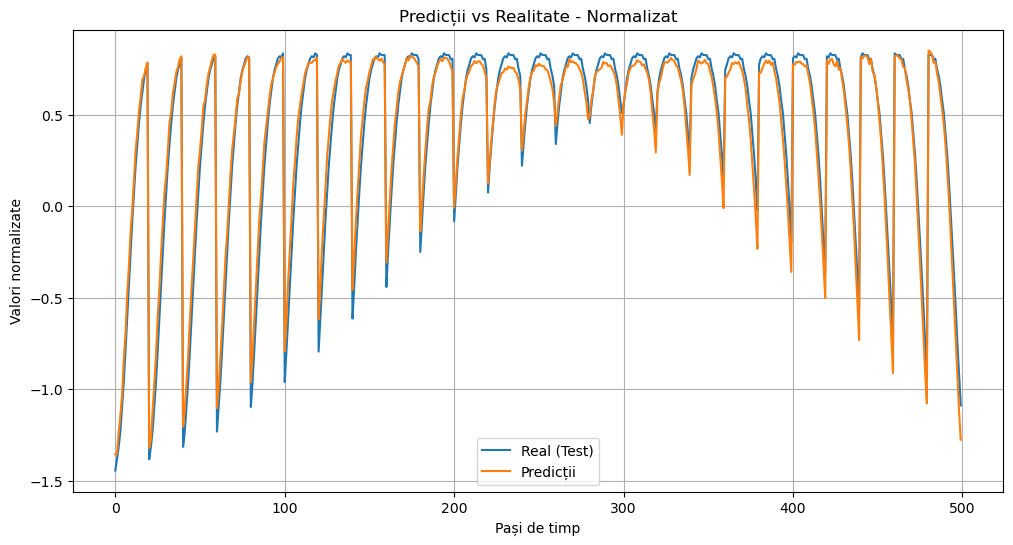

In [15]:
# Predictii pe setul de test (date normalizate)
y_pred_norm = model.predict(X_test, verbose=0).flatten()
y_test_norm = y_test.flatten()

# Calcul metrici pe valori normalizate
mse_norm = mean_squared_error(y_test_norm, y_pred_norm)
mae_norm = mean_absolute_error(y_test_norm, y_pred_norm)
rmse_norm = np.sqrt(mse_norm)
r2_norm = r2_score(y_test_norm, y_pred_norm)
mape_norm = np.mean(np.abs((y_test_norm - y_pred_norm) / y_test_norm)) * 100

print(f"🏆 Performanța modelului (date normalizate):")
print(f"   ├── MSE: {mse_norm:.8f}")
print(f"   ├── MAE: {mae_norm:.8f}")
print(f"   ├── RMSE: {rmse_norm:.8f}")
print(f"   ├── MAPE: {mape_norm:.2f}%")
print(f"   └── R²: {r2_norm:.6f} ({r2_norm*100:.2f}%)")

# Plot pe date normalizate
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm[:500], label='Real (Test)')
plt.plot(y_pred_norm[:500], label='Predicții')
plt.title('Predicții vs Realitate - Normalizat')
plt.xlabel('Pași de timp')
plt.ylabel('Valori normalizate')
plt.legend()
plt.grid(True)
plt.show()
